<a href="https://colab.research.google.com/github/sjsjlee/Bicycle-rental-volume-prediction-contest-in-Seoul/blob/main/%EB%94%B0%EB%A6%89%EC%9D%B4_%EC%98%88%EC%B8%A1_%EA%B2%BD%EC%A7%84_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import pandas as pd
import numpy as np
import warnings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
warnings.filterwarnings('ignore')

bicycle = pd.read_csv('/content/drive/MyDrive/dataset/train.csv')

In [ ]:
bicycle.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833


In [ ]:
bicycle.columns

Index(['date_time', 'wind_direction', 'sky_condition', 'precipitation_form',
       'wind_speed', 'humidity', 'low_temp', 'high_temp',
       'Precipitation_Probability', 'number_of_rentals'],
      dtype='object')

In [ ]:
def check_missing_col(dataframe):
    counted_missing_col = 0
    for i, col in enumerate(bicycle.columns):
        missing_values = sum(bicycle[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'총 {missing_values}개의 결측치가 존재합니다.')

        if i == len(bicycle.columns) - 1 and counted_missing_col == 0:
            print('결측치가 존재하지 않습니다')

check_missing_col(bicycle) 

결측치가 존재하지 않습니다


In [ ]:
# 결측치 존재하지 않음

bicycle.isnull().sum()

date_time                    0
wind_direction               0
sky_condition                0
precipitation_form           0
wind_speed                   0
humidity                     0
low_temp                     0
high_temp                    0
Precipitation_Probability    0
number_of_rentals            0
dtype: int64

In [38]:
def separate_datetime(dataframe):
  year = []
  month = []
  day = []
  
  for date in dataframe.date_time :
    year_point, month_point, day_point = date.split('-')
    year.append(int(year_point))
    month.append(int(month_point))
    day.append(int(day_point))
  return year, month, day

year, month, day = separate_datetime(bicycle)

bicycle['year'] = year
bicycle['month'] = month
bicycle['day'] = day

bicycle.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,year,month,day
0,2018-04-01,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994,2018,4,1
1,2018-04-02,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139,2018,4,2
2,2018-04-03,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817,2018,4,3
3,2018-04-04,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034,2018,4,4
4,2018-04-05,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833,2018,4,5


In [39]:
X = bicycle.drop(['date_time', 'number_of_rentals'], axis = 1)
y = bicycle.number_of_rentals

In [ ]:
# 선형회귀분석 모델

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_hat = model.predict(X)

In [ ]:
name = np.mean(abs(y_hat -y)/y)

name

0.3234797521201353

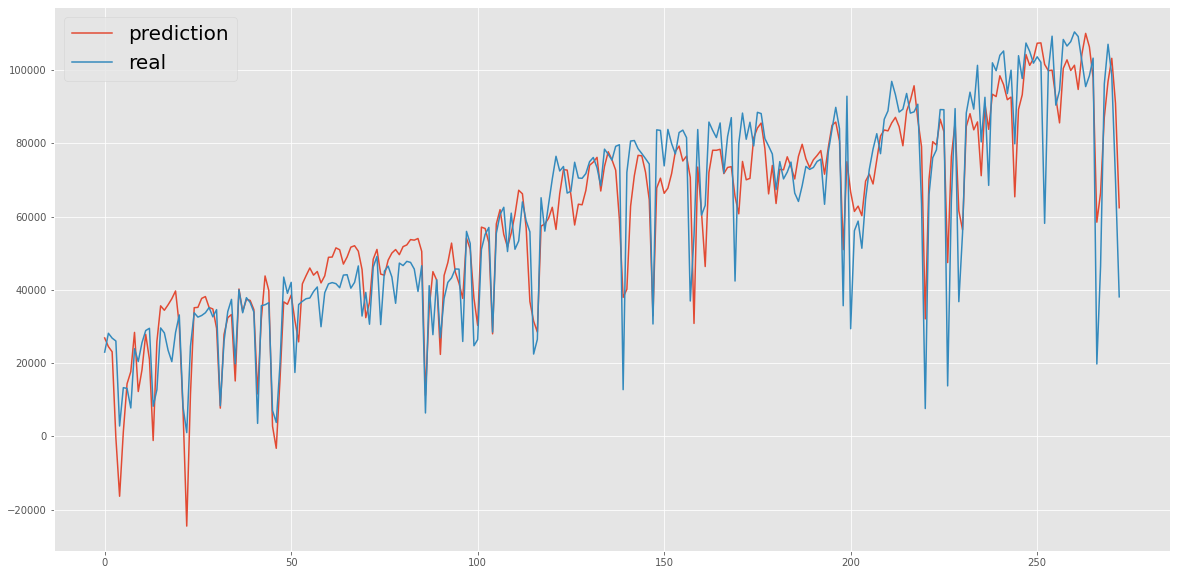

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize = (20,10))
plt.plot(y_hat, label = 'prediction')
plt.plot(y, label = 'real')
plt.legend(fontsize = 20)
plt.show()

In [46]:
# 새 변수 추가 - 요일
import datetime as dt

bicycle['date_time'] = pd.to_datetime(bicycle['date_time'])
bicycle['day_of_week'] = bicycle['date_time'].dt.day_name() #문자형 - 그래프 통해 확인

In [41]:
# 새변수 추가 - 불쾌지수
temperature = bicycle['high_temp']
humidity = bicycle['humidity']

bicycle['discomfort_index'] = 1.8*temperature-0.55*(1-humidity/100)*(1.8*temperature-26)+32

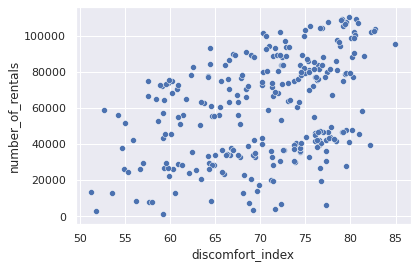

In [42]:
import seaborn as sns

sns.scatterplot(data = bicycle, x= 'discomfort_index', y = 'number_of_rentals')

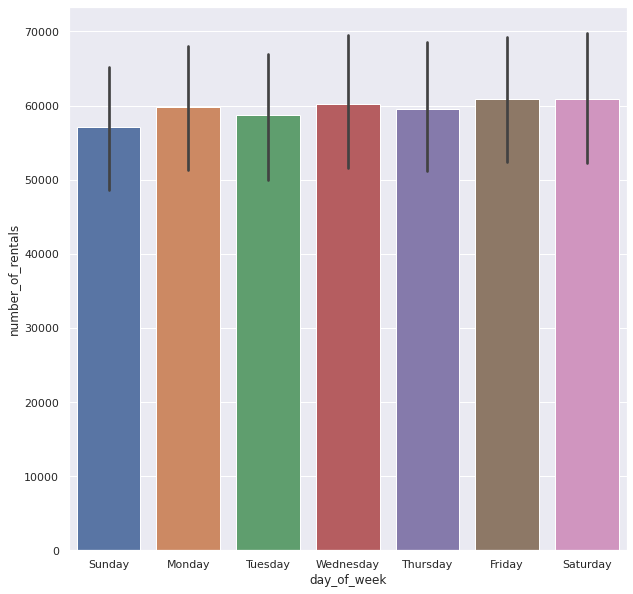

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))
bar = sns.barplot(data = bicycle, x = 'day_of_week', y = 'number_of_rentals') #요일과 렌탈수와 별로 연관이 없음

In [48]:
bicycle = bicycle.drop(['day_of_week'], axis =1)

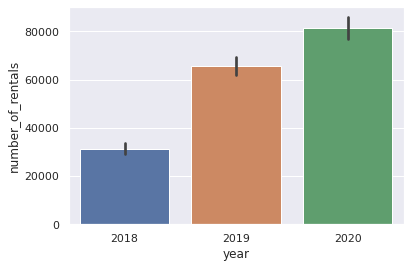

In [49]:
sns.barplot(data = bicycle, x= 'year', y ='number_of_rentals')

#연도별로 꾸준히 증가함을 알 수 있음

In [ ]:
# 선형회귀분석 유의한 변수 확인하기

import statsmodels.api as sm

# 변수 지정
x = bicycle[['wind_direction', 'sky_condition', 'precipitation_form',
       'wind_speed', 'humidity', 'low_temp', 'high_temp',
       'Precipitation_Probability', 'year', 'month', 'day']]
target = bicycle.number_of_rentals

x_data = sm.add_constant(x, has_constant = "add")
ln_reg = sm.OLS(target, x_data).fit()
ln_reg.summary()

# 0.1 수준에서 유의한 변수들 : const, wind_direction, wind_speed, high_temp, year, month
# 확실히 제외할 변수들 : sky_condition, humidity, day, Precipitation_Probability	

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      number_of_rentals   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     140.8
Date:                Tue, 09 Nov 2021   Prob (F-statistic):          6.41e-103
Time:                        06:14:03   Log-Likelihood:                -2914.8
No. Observations:                 273   AIC:                             5854.
Df Residuals:                     261   BIC:                             5897.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -4.725e+07   1.68e+06    -28.069      0.000   -5.06e+07   -4.39e+07
wind_direction               24.5096     13.247      1.850      0.065      -1.576      50.595
sky_condition              1931.0067   4713.097      0.410      0.682   -7349.528    1.12e+04
precipitation_form        -2.136e+04    2.2e+04     -0.971      0.332   -6.47e+04     2.2e+04
wind_speed                -4157.0248    928.661     -4.476      0.000   -5985.646   -2328.403
humidity                     37.0412     88.243      0.420      0.675    -136.718     210.801
low_temp                   -476.5680    515.771     -0.924      0.356   -1492.170     539.034
high_temp                  1484.3219    419.221      3.541      0.000     658.836    2309.807
Precipitation_Probability  -362.3927    483.284     -0.750      0.454   -1314.025     589.239
year                       2.341e+04    833.801     28.077      0.000    2.18e+04    2.51e+04
month                      4797.1030   2097.915      2.287      0.023     666.109    8928.097
day                          45.6440     91.817      0.497      0.620    -135.153     226.441
==============================================================================
Omnibus:                       38.714   Durbin-Watson:                   1.603
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.198
Skew:                          -0.706   Prob(JB):                     5.21e-19
Kurtosis:                       5.325   Cond. No.                     5.27e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.27e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# 변수 추가 타당성 검증 -> 수정된 r-squared 값 증가함, f통계량 유의함
 
x = bicycle[['wind_direction', 'sky_condition', 'precipitation_form',
       'wind_speed', 'humidity', 'low_temp', 'high_temp',
       'Precipitation_Probability', 'year', 'month', 'day', 'discomfort_index']]
target = bicycle.number_of_rentals

x_data = sm.add_constant(x, has_constant = "add")
ln_reg = sm.OLS(target, x_data).fit()
ln_reg.summary()

# 유의한 변수들 : wind_direction, wind_speed, humidity, year, month, discomfot_index
# 애매한 변수들 : low_temp, precipitation_probablity, day

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      number_of_rentals   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     132.8
Date:                Mon, 08 Nov 2021   Prob (F-statistic):          2.15e-103
Time:                        07:39:37   Log-Likelihood:                -2911.0
No. Observations:                 273   AIC:                             5848.
Df Residuals:                     260   BIC:                             5895.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      -4.83e+07   1.71e+06    -28.283      0.000   -5.17e+07   -4.49e+07
wind_direction               31.5956     13.349      2.367      0.019       5.310      57.882
sky_condition              3133.3401   4678.149      0.670      0.504   -6078.544    1.23e+04
precipitation_form        -1.742e+04   2.18e+04     -0.800      0.424   -6.03e+04    2.55e+04
wind_speed                -3970.7893    920.186     -4.315      0.000   -5782.755   -2158.824
humidity                    292.6100    128.529      2.277      0.024      39.520     545.700
low_temp                   -466.5942    509.647     -0.916      0.361   -1470.154     536.966
high_temp                  5834.5146   1659.868      3.515      0.001    2566.019    9103.010
Precipitation_Probability  -484.6153    479.663     -1.010      0.313   -1429.135     459.904
year                       2.398e+04    850.511     28.197      0.000    2.23e+04    2.57e+04
month                      6038.8082   2123.113      2.844      0.005    1858.122    1.02e+04
day                          92.4323     92.357      1.001      0.318     -89.431     274.295
discomfort_index          -3326.6719   1229.170     -2.706      0.007   -5747.067    -906.277
==============================================================================
Omnibus:                       41.755   Durbin-Watson:                   1.640
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.547
Skew:                          -0.764   Prob(JB):                     3.59e-20
Kurtosis:                       5.353   Cond. No.                     5.41e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.41e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# 제외하고 다시 선형회귀분석

x = x.drop(['sky_condition', 'precipitation_form', 'day'], axis =1)
target = bicycle.number_of_rentals

x_data = sm.add_constant(x, has_constant = "add")
ln_reg = sm.OLS(target, x_data).fit()
ln_reg.summary()

# low_temp 제외하고 어느정도 유의함을 확인할 수 있음 : wind_direction, precipitation_probability, wind_speed, humidity, high_temp, year, month 선택

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      number_of_rentals   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     166.8
Date:                Mon, 08 Nov 2021   Prob (F-statistic):          2.68e-103
Time:                        07:39:42   Log-Likelihood:                -2919.2
No. Observations:                 273   AIC:                             5858.
Df Residuals:                     263   BIC:                             5895.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -4.723e+07   1.72e+06    -27.400      0.000   -5.06e+07   -4.38e+07
wind_direction               30.1125     13.494      2.232      0.026       3.542      56.683
wind_speed                -4685.9537    910.828     -5.145      0.000   -6479.397   -2892.510
humidity                    267.8325    131.422      2.038      0.043       9.059     526.606
low_temp                   -100.3019    489.585     -0.205      0.838   -1064.308     863.704
high_temp                  4775.2291   1657.432      2.881      0.004    1511.703    8038.755
Precipitation_Probability  -532.8822     67.139     -7.937      0.000    -665.081    -400.683
year                       2.345e+04    858.558     27.312      0.000    2.18e+04    2.51e+04
month                      5138.3421   1813.815      2.833      0.005    1566.896    8709.788
discomfort_index          -2738.3146   1226.481     -2.233      0.026   -5153.286    -323.343
==============================================================================
Omnibus:                       43.360   Durbin-Watson:                   1.650
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.592
Skew:                          -0.802   Prob(JB):                     2.13e-20
Kurtosis:                       5.322   Cond. No.                     5.33e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.33e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
#상관관계 분석

import scipy.stats as stats

for item in X:
  print(item)
  x = bicycle[item].values 
  print('Correlation : {:.2f}'.format(stats.pearsonr(x, y)[0]))
  print('P-value : {:.4f}'.format(stats.pearsonr(x, y)[1]))
  print('\n')

  '''
  0.2 이상 : wind_direction
  0.3 이상 : sky_condition, low_temp, month
  0.4 이상 : precipitation_form, wind_speed, high_temp, Precipitation_Probability, discomfot
  0.7 이상 : year
  0.2 이하 , 제외 : humidity, day
  '''

wind_direction
Correlation : 0.21
P-value : 0.0005


sky_condition
Correlation : -0.38
P-value : 0.0000


precipitation_form
Correlation : -0.42
P-value : 0.0000


wind_speed
Correlation : -0.46
P-value : 0.0000


humidity
Correlation : -0.15
P-value : 0.0145


low_temp
Correlation : 0.32
P-value : 0.0000


high_temp
Correlation : 0.42
P-value : 0.0000


Precipitation_Probability
Correlation : -0.45
P-value : 0.0000


year
Correlation : 0.74
P-value : 0.0000


month
Correlation : 0.32
P-value : 0.0000


day
Correlation : 0.05
P-value : 0.4035




In [ ]:
# 후진소거법

import statsmodels.api as sm

variables = bicycle.drop(['date_time', 'number_of_rentals'], axis=1).columns.tolist()
selected_variables = []
alpha = 0.1

df = bicycle.drop(['date_time'], axis = 1)
sv_per_steps = []
adjusted_r_squared = []
steps = []
step = 0

sv_per_step = [] ## 각 스텝별로 선택된 변수들
adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
steps = [] ## 스텝
step = 0
while len(variables) > 0:
    remainder = list(set(variables) - set(selected_variables))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    for col in remainder: 
        X = df[selected_variables+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]
 
    min_pval = pval.min()
    if min_pval < alpha: ## 최소 p-value 값이 기준 값보다 작으면 포함
        selected_variables.append(pval.idxmin())
        
        step += 1
        steps.append(step)
        adj_r_squared = sm.OLS(y,sm.add_constant(df[selected_variables])).fit().rsquared_adj
        adjusted_r_squared.append(adj_r_squared)
        sv_per_step.append(selected_variables.copy())
    else:
        break

In [ ]:
selected_variables

['year',
 'high_temp',
 'precipitation_form',
 'wind_speed',
 'wind_direction',
 'month',
 'discomfort_index',
 'humidity',
 'Precipitation_Probability']

In [ ]:
'''
선형회귀분석 유의 변수 : wind_direction, precipitation_probability, wind_speed, humidity, high_temp, year, month, discomfort_index
상관관계 0.2 이상 변수 : wind_direction, sky_condition, low_temp, month, precipitation_form, wind_speed, high_temp, Precipitation_Probability, discomfort_index, year 
후진소거법 선택변수 : 'year', 'high_temp', 'precipitation_form', 'wind_speed', 'wind_direction', 'month', 'discomfort_index','humidity','Precipitation_Probability'

공통 변수 : wind_direction, wind_speed, high_temp, discomfort_index, year, month
2개이상 포함 변수 : 'Precipitation_Probability', 'precipitation_form' ->추가해보면서 확인해보기


* 선형회귀분석 유의 변수 : wind_direction, precipitation_probability, wind_speed, humidity, high_temp, year, month, discomfort_index

* 상관관계 0.2 이상 변수 : wind_direction, sky_condition, low_temp, month, precipitation_form, wind_speed, high_temp, Precipitation_Probability, discomfort_index, year 

* 후진소거법 선택변수 : 'year', 'high_temp', 'precipitation_form', 'wind_speed', 'wind_direction', 'month', 'discomfort_index','humidity','Precipitation_Probability'

* 공통 변수 : wind_direction, wind_speed, high_temp, discomfort_index, year, month
* 2개이상 포함 변수 : 'Precipitation_Probability', 'precipitation_form' ->추가해보면서 확인해보기

In [58]:
#1차 변수

X = bicycle[['wind_direction', 'wind_speed', 'Precipitation_Probability', 'high_temp', 'discomfort_index', 'year', 'month']]
Y = bicycle.number_of_rentals

In [152]:
#2차변수('Precipitation_Probability' 추가) ->이게가장설명력좋음

X = bicycle[['wind_direction', 'wind_speed', 'Precipitation_Probability', 'high_temp', 'discomfort_index', 'year', 'month']]
Y = bicycle.number_of_rentals

In [59]:
# 3차변수('precipitation_form' 추가)

X = bicycle[['wind_direction', 'wind_speed', 'precipitation_form', 'high_temp', 'discomfort_index', 'year', 'month']]
Y = bicycle.number_of_rentals

In [ ]:
#4차변수('precipitation_form', 'Precipitation_Probability' 추가)

X = bicycle[['wind_direction', 'wind_speed', 'precipitation_form', 'Precipitation_Probability', 'high_temp', 'discomfort_index', 'year', 'month']]
Y = bicycle.number_of_rentals

In [153]:
#test_train_split

from sklearn.model_selection import train_test_split


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 10)


In [64]:
colnames = X_train.columns
new_colnames = [i for i in colnames]

In [71]:
# 데이터 전처리 - MinmaxScaler

from sklearn.preprocessing import MinMaxScaler
mm_scaler = MinMaxScaler()

mm_scaler.fit(X_train)
X_train_scaled = mm_scaler.transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

minmax_Xtrain = pd.DataFrame(X_train_scaled, index = X_train.index, columns = new_colnames)
minmax_Xtest = pd.DataFrame(X_test_scaled, index = X_test.index, columns = new_colnames)

In [154]:
## RobustScaler -> 선택

from sklearn.preprocessing import RobustScaler
rob_scaler = RobustScaler()

rob_scaler.fit(X_train)
X_train_robust = rob_scaler.transform(X_train)
X_test_robust = rob_scaler.transform(X_test)

robust_Xtrain = pd.DataFrame(X_train_robust, index = X_train.index, columns = new_colnames)
robust_Xtest = pd.DataFrame(X_test_robust, index = X_test.index, columns = new_colnames)

In [73]:
## StandardScaler

from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()

standard_scaler.fit(X_train)
X_train_st = standard_scaler.transform(X_train)
X_test_st = standard_scaler.transform(X_test)

st_Xtrain = pd.DataFrame(X_train_st, columns = new_colnames, index = X_train.index)
st_Xtest = pd.DataFrame(X_test_st, columns = new_colnames, index = X_test.index)

In [74]:
## MaxAbsScaler

from sklearn.preprocessing import MaxAbsScaler
abs_scaler = MaxAbsScaler()

abs_scaler.fit(X_train)
X_train_abs = abs_scaler.transform(X_train)
X_test_abs = abs_scaler.transform(X_test)

abs_Xtrain = pd.DataFrame(X_train_abs, columns = new_colnames, index = X_train.index)
abs_Xtest = pd.DataFrame(X_test_abs, columns = new_colnames, index = X_test.index)

In [108]:
#XGBRegressor

from xgboost import XGBRegressor # 0.33

xgb_model = XGBRegressor(max_depth = 5, n_estimators = 1500, learning_rate= 0.1, alpha = 10) #objective='reg:squarederror'
xgb_model.fit(minmax_Xtrain, Y_train)

[10:06:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=1500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [109]:
#random forest regression

from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(max_depth = 5, n_estimators = 1000)
rf_model.fit(minmax_Xtrain, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [147]:
# 그래디언트 부스팅 - standard

from sklearn.ensemble import GradientBoostingRegressor

standard_model = GradientBoostingRegressor(random_state = 9, max_depth = 5, n_estimators = 1500, learning_rate= 0.1)
standard_model.fit(st_Xtrain, Y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=9, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [84]:
# 그래디언트 부스팅 - minmax

from sklearn.ensemble import GradientBoostingRegressor

minmax_model = GradientBoostingRegressor(random_state = 9, max_depth = 5, n_estimators = 1500, learning_rate= 0.1)
minmax_model.fit(minmax_Xtrain, Y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=9, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [155]:
_# 그래디언트 부스팅 - robust

from sklearn.ensemble import GradientBoostingRegressor

robust_model = GradientBoostingRegressor(random_state = 9, max_depth = 5, n_estimators = 1500, learning_rate= 0.1)
robust_model.fit(robust_Xtrain, Y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=9, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [141]:
# 그래디언트 부스팅 - maxabs

from sklearn.ensemble import GradientBoostingRegressor

maxabs_model = GradientBoostingRegressor(random_state = 9, max_depth = 5, n_estimators = 1500, learning_rate= 0.1)
maxabs_model.fit(abs_Xtrain, Y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=9, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [112]:
xgb_y_pred = xgb_model.predict(X_test)

In [113]:
rf_y_pred = rf_model.predict(X_test)

In [87]:
mm_y_pred = minmax_model.predict(minmax_Xtest)

In [88]:
st_y_pred = standard_model.predict(st_Xtest)

In [89]:
rob_y_pred = robust_model.predict(robust_Xtest)

In [90]:
abs_y_pred = maxabs_model.predict(abs_Xtest)

In [115]:
nmae = np.mean((xgb_y_pred -Y_test)/Y_test)

nmae

0.22915343480568315

In [114]:
nmae = np.mean((rf_y_pred -Y_test)/Y_test)

nmae

0.8086655456264514

In [91]:
nmae = np.mean(abs(mm_y_pred -Y_test)/Y_test)

nmae

0.17773152533610687

In [92]:
nmae = np.mean(abs(st_y_pred -Y_test)/Y_test)

nmae

0.1776457217301563

In [156]:
nmae = np.mean(abs(rob_y_pred -Y_test)/Y_test) #근소한 차이로 robust scaler 선택

nmae #근소한 차이로 robust scaler 선택

0.17741849371098592

In [94]:
nmae = np.mean(abs(abs_y_pred -Y_test)/Y_test)

nmae

0.1776286035752784

In [107]:
rob_y_pred

array([ 45576.50425133,  27701.92405658,  78776.2579682 ,  69784.35907026,
        40584.89342646,  72502.63803875,  71340.7061027 ,   6686.55546625,
        80488.97953559,  73790.65722182,  71940.97238557,   8942.55403447,
        41442.21693393,  98446.49716387,  93220.75663869,  91333.36026699,
        42871.52453939,  77640.41749263,  18440.68669547,  78890.48071983,
        47146.48074579,  74735.11856955,  42557.41438467,  60291.84318751,
        13621.99403259,  39739.77118605,  35195.50826022,  82142.89557555,
       102312.27703516,  74360.13850591,  38869.10993812,  93518.92679108,
        85522.71406438,  91777.01107182,  59447.70372304,  80705.55544513,
        72652.35690369,  24348.87889671,  94061.72083667,  47324.22635567,
        44684.11812985,  93045.99222085, 102368.17632479,  50298.25951195,
        50268.46852754,  75390.83524348,  84160.27388035, 102944.6298086 ,
        65382.20120091,  27858.0069529 ,  35883.73139071,  30878.09209314,
        85778.9629075 ,  

In [105]:
#Y_test의 array화

y_test = Y_test.to_numpy()

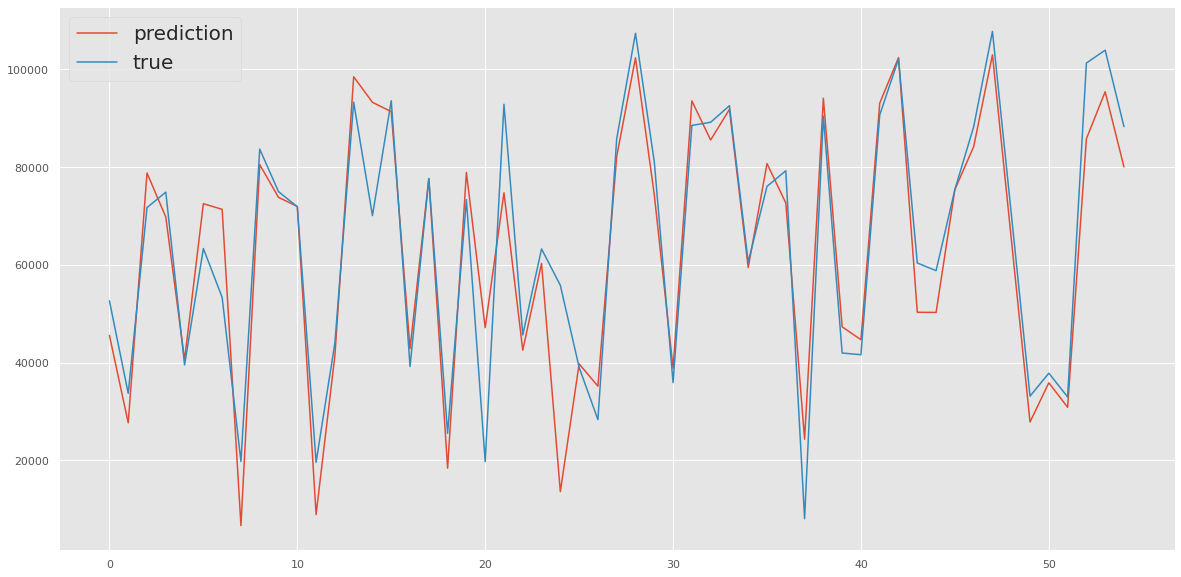

In [106]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize = (20,10))
plt.plot(rob_y_pred, label = 'prediction')
plt.plot(y_test, label = 'true')
plt.legend(fontsize = 20)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth' : [3,4,5,6], 'random_state' : [7,8,9,10]}

model = GradientBoostingRegressor()
grid_dtree = GridSearchCV(model, param_grid = parameters, cv = 3, refit=True)

grid_dtree.fit(X_train, Y_train)

scores_df = pd.DataFrame(grid_dtree.cv_results_)


In [180]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth' : [5,6,7], 'random_state' : [9, 10, 11]}

model = GradientBoostingRegressor()
grid_dtree = GridSearchCV(model, param_grid = parameters, cv = 3, refit=True)

grid_dtree.fit(robust_Xtrain, Y_train)

scores_df = pd.DataFrame(grid_dtree.cv_results_)


In [181]:
scores_df = scores_df[['params', 'mean_test_score', 'rank_test_score', 
           'split0_test_score', 'split1_test_score', 'split2_test_score']]

In [182]:
scores_df.sort_values(by = 'rank_test_score').head()

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'max_depth': 5, 'random_state': 9}",0.822656,1,0.825555,0.734476,0.907937
2,"{'max_depth': 5, 'random_state': 11}",0.819874,2,0.817775,0.733193,0.908654
1,"{'max_depth': 5, 'random_state': 10}",0.819739,3,0.820272,0.729846,0.909100
3,"{'max_depth': 6, 'random_state': 9}",0.798370,4,0.824120,0.687057,0.883932
5,"{'max_depth': 6, 'random_state': 11}",0.796881,5,0.808353,0.695545,0.886744


In [ ]:
# LSTM -> 학습률 떨어짐

x_train = minmax_Xtrain.values
x_test = minmax_Xtest.values
y_train = Y_train.to_numpy()
y_test = Y_test.to_numpy()

In [ ]:
x_train_t = x_train.reshape(x_train.shape[0], 7, 1)
x_test_t = x_test.reshape(x_test.shape[0], 7, 1)
y_train_t = y_train.reshape(y_train.shape[0], 1)
y_test_t = y_test.reshape(y_test.shape[0], 1)

In [ ]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

K.clear_session()
model = Sequential()
model.add(LSTM(20, input_shape = (x_train_t.shape[1],x_train_t.shape[2]), activation = 'relu', return_sequences= False))
model.add(Dense(1)) #output = 1
model.compile(loss='mean_absolute_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                1760      
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stop = EarlyStopping(monitor = 'loss', patience = 1, verbose =1)

model.fit(x_train_t, y_train_t, epochs = 100,
          batch_size = 1000, verbose =  1, callbacks = [early_stop])

Epoch 1/100
1/1 [==============================] - 0s 10ms/step - loss: 26010.1211
Epoch 2/100
1/1 [==============================] - 0s 13ms/step - loss: 25921.4785
Epoch 3/100
1/1 [==============================] - 0s 10ms/step - loss: 25835.4688
Epoch 4/100
1/1 [==============================] - 0s 11ms/step - loss: 25744.7070
Epoch 5/100
1/1 [==============================] - 0s 12ms/step - loss: 25648.5840
Epoch 6/100
1/1 [==============================] - 0s 12ms/step - loss: 25554.6094
Epoch 7/100
1/1 [==============================] - 0s 13ms/step - loss: 25479.0605
Epoch 8/100
1/1 [==============================] - 0s 14ms/step - loss: 25411.5566
Epoch 9/100
1/1 [==============================] - 0s 13ms/step - loss: 25347.6133
Epoch 10/100
1/1 [==============================] - 0s 12ms/step - loss: 25312.5352
Epoch 11/100
1/1 [==============================] - 0s 12ms/step - loss: 25287.2949
Epoch 12/100
1/1 [==============================] - 0s 12ms/step - loss: 25271.8633
E

In [ ]:
score = model.evaluate(x_test_t, y_test_t, batch_size = 30)

2/2 [==============================] - 0s 5ms/step - loss: 26577.6309


In [ ]:
Y_pred = model.predict(x_test_t)

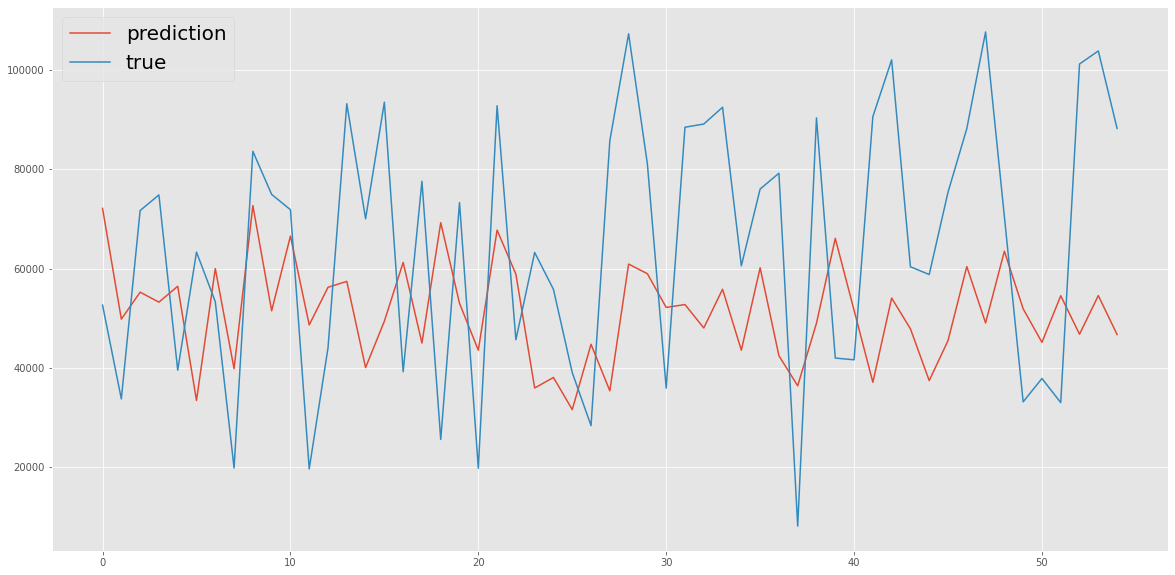

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize = (20,10))
plt.plot(Y_pred, label = 'prediction')
plt.plot(y_test_t, label = 'true')
plt.legend(fontsize = 20)
plt.show()

In [163]:
#테스트 데이터셋에 적용

test_df = pd.read_csv("/content/drive/MyDrive/dataset/test.csv")
submission = pd.read_csv("/content/drive/MyDrive/dataset/sample_submission.csv")


year, month, day = separate_datetime(test_df)

test_df['year'] = year
test_df['month'] = month
test_df['day'] = day

test_df.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,year,month,day
0,2021-04-01,108.833,3.000,0.000,2.900,28.333,11.800,20.667,18.333,2021,4,1
1,2021-04-02,116.717,3.850,0.000,2.662,46.417,12.000,19.000,28.500,2021,4,2
2,2021-04-03,82.669,4.000,0.565,2.165,77.258,8.875,16.368,52.847,2021,4,3
3,2021-04-04,44.123,3.466,0.466,3.747,63.288,6.250,17.368,37.671,2021,4,4
4,2021-04-05,147.791,1.500,0.000,1.560,48.176,7.188,18.684,4.459,2021,4,5


In [164]:
temp = test_df['high_temp']
humid = test_df['humidity']

test_df['discomfort_index'] = 1.8*temp-0.55*(1-humid/100)*(1.8*temp-26)+32

In [165]:
test_X = test_df[['wind_direction', 'wind_speed', 'Precipitation_Probability', 'high_temp', 'discomfort_index', 'year', 'month']]

In [168]:
test_X_transformed = rob_scaler.transform(test_X)

colnames = test_X.columns
new_colnames = [i for i in colnames]

X_test_transformed = pd.DataFrame(test_X_transformed, index = test_X.index, columns = new_colnames)

In [169]:
test_Y_pred = robust_model.predict(X_test_transformed)

In [170]:
submission['number_of_rentals'] = test_Y_pred

In [171]:
submission.to_csv('/content/drive/MyDrive/dataset/submission_final.csv', index=False)

In [172]:
test_Y_pred

array([ 65576.1345507 ,  45334.22423096,  22046.83300322,  25522.49526971,
        81754.75023552,  76874.77352784,  75156.29781908,  74611.62104224,
        80228.13351503,  82960.49460895,  80757.51246628,  23667.92712618,
        57891.68064246,  70829.35912377,  77824.20808802,  63688.3500358 ,
        69358.34916322,  82436.02840885,  86919.07393415,  95916.89733019,
        87766.94545871,  81336.2062832 ,  75530.49332172,  67069.44446656,
        84669.10413205,  82190.93569409,  63336.66999831,  62680.84541699,
        60011.48734643,  38805.41930059,  49423.09458311,  77157.30278383,
        82134.93200654,  43839.64103222,  78099.53934944,  84511.56376382,
        75210.3392949 ,  77378.38691165,  78123.01642641,  65494.86888592,
       102838.28817307,  96123.36988829, 101452.31584101,  96736.98237588,
        54061.8733363 ,   9489.3309295 ,  58940.24039357,  98168.18701913,
        99400.39858108,  72887.22815966,  65155.51206749,  94377.79299956,
        95756.63389899,  